# University of Utah Snow-to-Liquid Ratio Algorithm (v2019)
#### Code by Michael Wessler (Jim Steenburgh research group)
Based on original work by Trevor Alcott<br>
Alcott and Steenburgh (2010; https://doi.org/10.1175/2009WAF2222311.1)<br><br>
Technique used here is a simplified version of the stepwise multiple linear regression (SMLR) method used in the paper.<br>
A curve fit is used to estimate the SMLR SLR output based on limited predictors for computational simplicity.<br>
This is the method evaluated in the 2019-2020 WPC-HMT Winter Weather Experiment. New methods in development.

## Core imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pandas import to_datetime

## Sample Data for Unit Testing
4-dimensional data (time, level, lat, lon) provided but can use a combination of lower dimensional data (level is the only required dimension).<br>
Data may come from grib or any other format, but must conform to this structure for functions to work as they are provided.<br>
Note the QPF in this sample dataset is a 3-hourly accumulation (APCP) to conform with other 3-hourly variables.<br>
Model orography (orog) can and likely should be replaced with a higher resolution Digital Elevation Model (DEM).

In [2]:
data = xr.open_dataset('./GFS_0p25_2020011500.sample.nc')
data

<xarray.Dataset>
Dimensions:  (level: 13, time: 30, x: 121, y: 81)
Coordinates:
  * level    (level) int64 1000 975 950 925 900 850 800 750 700 650 600 550 500
  * time     (time) datetime64[ns] 2020-01-15 ... 2020-01-18T15:00:00
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    t        (time, level, y, x) float32 ...
    tw       (time, level, y, x) float64 ...
    gh       (time, level, y, x) float32 ...
    qpf      (time, y, x) float64 ...
    orog     (time, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-08-13T08:35:43 GRIB to CDM+CF via cfgrib-0....

## Wet Bulb Zero Height (Snow Level Proxy)

In [3]:
def calc_wet_bulb_zero_height(tw, gh, orog):
    
    ''' 
    Function to calculate the height of the wet bulb zero (wbzh)
    (or other chosen wet bulb temperature)
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        tw : xr.DataArray
            1-D (vertical) or n-D array of Wet Bulb Temperature (C)

        gh : xr.DataArray
            1-D (vertical) or n-D array of geopotential height (m)
            Note if model provides true geopotential divide by g=9.80665 
            to obtain the geopotential height in meters

        orog : array_like
            Scalar or xr.DataArray of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        wbzh : xr.DataArray or scalar
            The height of the wet bulb zero parameter in meters above sea level
            This is a scalar if tw and gh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # WBZ parameter: temperature to search for 
    # 0.5 degC as in Western Region tech. attachment
    wbzparam = 0.5
    
    for i, level in enumerate(tw.level.values):
        
        if i > 0:

            level_top = tw.isel(level=i).level.values
            level_bot = tw.isel(level=i-1).level.values
            print('Searching for WBZ between %d and %d hPa'%(level_bot, level_top))

            gh_top = gh.isel(level=i)
            gh_bot = gh.isel(level=i-1)

            tw_top = tw.isel(level=i)
            tw_bot = tw.isel(level=i-1)

            # Linear interpolation of wbz height to use when/if it is between these two levels
            interp_wbzh = gh_bot + ((wbzparam - tw_bot)*((gh_top - gh_bot)/(tw_top - tw_bot)))

            if i == 1:
                # First iteration, establish the wbz height (wbzh) array
                # If WBZ between these two levels, use interpolated WBZH, else np.nan
                wbzh = xr.where( (tw_bot >= wbzparam) & (tw_top <= wbzparam), interp_wbzh, np.nan)

            else:
                # If does not exist:
                wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (np.isnan(wbzh)), interp_wbzh, wbzh)

                # If exists and wbzh subterrainian
                wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (~np.isnan(wbzh) & (wbzh >= orog.min())), interp_wbzh, wbzh)

    # Where nans remain because entire column Tw < wbzparam, fill with 0 m AMSL
    wbzh = xr.where(np.isnan(wbzh) & (tw.max(dim='level') < wbzparam), 0, wbzh)
    
    return wbzh.drop('level')

## Layer temperature calculation

In [4]:
def calc_layer_temp(t, gh, orog):
    
    ''' 
    Function to calculate the relevant layer temperature 
    as predictor for curve fit snow-liquid-ratio (SLR) calculation
    based on Alcott and Steenburgh (2010) Stepwise Multiple
    Linear Regression based SLR algorithm
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        t : xr.DataArray
            1-D (vertical) or n-D array of Wet Bulb Temperature (C)

        gh : xr.DataArray
            1-D (vertical) or n-D array of geopotential height (m)
            Note if model provides true geopotential divide by g=9.80665 
            to obtain the geopotential height in meters

        orog : array_like
            Scalar or xr.DataArray of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        tlayer : xr.DataArray or scalar
            Relevant layer temperature (predictor for SLR curve fit)
            This is a scalar if t and gh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # Determine geopotential height relative to ground level
    # + 500 m buffer (see Alcott(?), I believe this may have been done as a bias correction)
    gh_agl = (gh - (orog + 500.0))
    
    # Where this is 0.0 m, set to 1.0 m
    gh_agl = xr.where(gh_agl == 0.0, 1.0, gh_agl)
    
    # If the 1000mb height is > 0, use the 1000 mb temperature to start
    # Otherwise assign t=0
    tvals = xr.where(gh_agl.sel(level=1000) > 0, t.sel(level=1000), 0)
    
    # Iterate through the vertical levels
    for i in range(t.level.size)[:0:-1]:
        
        # 'l' level
        # 'z' geopotential height
        # 'c/up/dn' current level/level above/level below
        
        # Current level
        lc = t.level.isel(level=i).values
        zc = gh_agl.isel(level=i)
        tc = t.isel(level=i)
        
        # Level above (corrected for 'wraparound' when iterating)
        up = i+1 if i+1 < t.level.size else 0
        lup = t.level.isel(level=up).values
        zup = gh_agl.isel(level=up)
        tup = t.isel(level=up)
        
        # Level below (corrected for 'wraparound' when iterating)
        ldn = t.level.isel(level=i-1).values
        zdn = gh_agl.isel(level=i-1)
        tdn = t.isel(level=i-1)
        
        # Print values for a sanity check while testing 
        # to ensure proper iteration/vertical wrap
        # print(i, lc, lup, ldn)
        
        # Where the geopotential height AGL is > 0 at this level 
        # and geopotential height AGL is < 0 at level below...
        tvals = xr.where(((zc > 0.0) & (zdn < 0.0)),
        
        # Determine a layer temperature
        (( zc / ( zc - zup ) ) * ( tup - tc ) + tc ),
        
        # Else use layer temperature already determined
        tvals)
    
    # In the strange exception case where 500 mb is below ground level
    # apply T500 as Tlayer (redundant failsafe - probably not needed)
    tlayer = xr.where(gh_agl.sel(level=500) < 0, t.sel(level=500), tvals)
        
    return tlayer

## Snow-Liquid-Ratio Calculation

In [5]:
def calc_snow_ratio(tlayer, wbzh, orog):
    
    ''' 
    Function to calculate the relevant layer temperature 
    as predictor for curve fit snow-liquid-ratio (SLR) calculation
    based on Alcott and Steenburgh (2010) Stepwise Multiple
    Linear Regression based SLR algorithm
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        tlayer : xr.DataArray
            1-D (vertical) or n-D array of relevant layer temperature (C)
            predictor for SLR curve fit

        wbzh : xr.DataArray
            1-D (vertical) or n-D array of the height of 
            the wet bulb zero parameter (m)

        orog : array_like
            Scalar or xr.DataArray of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        slr : n-D array or scalar
            Snow-Liqud-Ratio value interger (e.g. 15 for 15:1)
            This is a scalar if tlayer and wbzh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # Tunable transition layer parameters (m)
    all_snow_buffer = 0
    transition_layer = 200
    
    # Extend the snow level below the wet bulb zero parameter height if set
    snow_level = wbzh - all_snow_buffer
    snow_level = xr.where(snow_level < 0., 0., snow_level)

    # Curve fit to Alcott and Steenburgh (2010) SMLR results
    init_slr = xr.where(tlayer < 0., 5. - tlayer, 5.)
    init_slr = xr.where(tlayer < -15., 20. + (tlayer + 15.), init_slr)
    init_slr = xr.where(tlayer < -20., 15., init_slr)

    # Keep the initial SLR calculations above the snow level
    slr = xr.where(orog >= snow_level, init_slr, 0.)

    # Linear attenuation of the SLR in the transition layer
    slr = xr.where(
        ((orog < snow_level) & (orog > (snow_level - transition_layer))),
        (init_slr * (orog - (snow_level - transition_layer)) / transition_layer), slr)

    return slr

## Calculate parameters, SLR

In [6]:
# Height of the Wet Bulb Zero 
data['wbzh'] = calc_wet_bulb_zero_height(data['tw'], data['gh'], data['orog'])

# Predictor Layer Temperature
data['tlayer'] = calc_layer_temp(data['t'], data['gh'], data['orog'])

# Snow-to-Liquid Ratio
data['slr'] = calc_snow_ratio(data['tlayer'], data['wbzh'], data['orog'])

# Quantitative Snowfall Forecast (QPF * SLR)
data['qsf'] = data['qpf'] * data['slr']

Searching for WBZ between 1000 and 975 hPa
Searching for WBZ between 975 and 950 hPa
Searching for WBZ between 950 and 925 hPa
Searching for WBZ between 925 and 900 hPa
Searching for WBZ between 900 and 850 hPa
Searching for WBZ between 850 and 800 hPa
Searching for WBZ between 800 and 750 hPa
Searching for WBZ between 750 and 700 hPa
Searching for WBZ between 700 and 650 hPa
Searching for WBZ between 650 and 600 hPa
Searching for WBZ between 600 and 550 hPa
Searching for WBZ between 550 and 500 hPa


## Create quickview plots

In [7]:
# Select a sample, verified file produced operationally on weather.utah.edu
verif = xr.open_dataset('GFSDS_20200115_0000_048.sample.nc')
verif_time = to_datetime(verif.time.values).strftime('%Y-%m-%d %H:%M')

idata = data.sel(time=verif_time)
time = to_datetime(idata.time.values).strftime('%Y-%m-%d %H:%M')

# Check for time match
print('fx: %s\nvx: %s'%(time, verif_time))

fx: 2020-01-17 00:00
vx: 2020-01-17 00:00


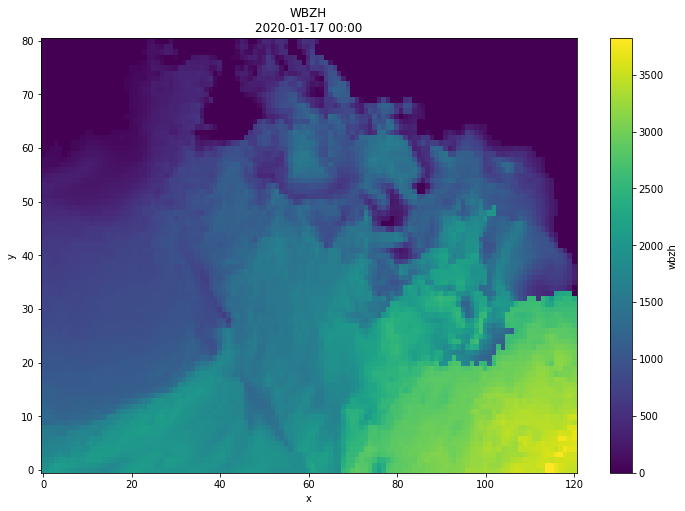

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 8), facecolor='w')
idata['wbzh'].plot(ax=ax)
ax.set_title('WBZH\n%s'%time)
plt.show()

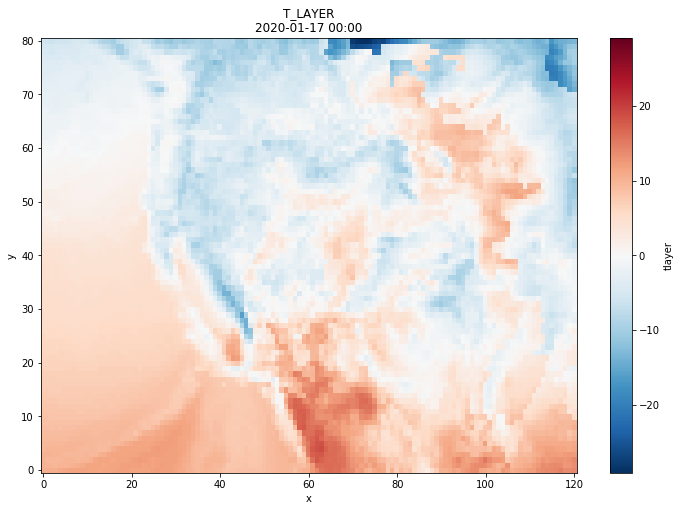

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8), facecolor='w')
idata['tlayer'].plot(ax=ax)
ax.set_title('T_LAYER\n%s'%time)
plt.show()

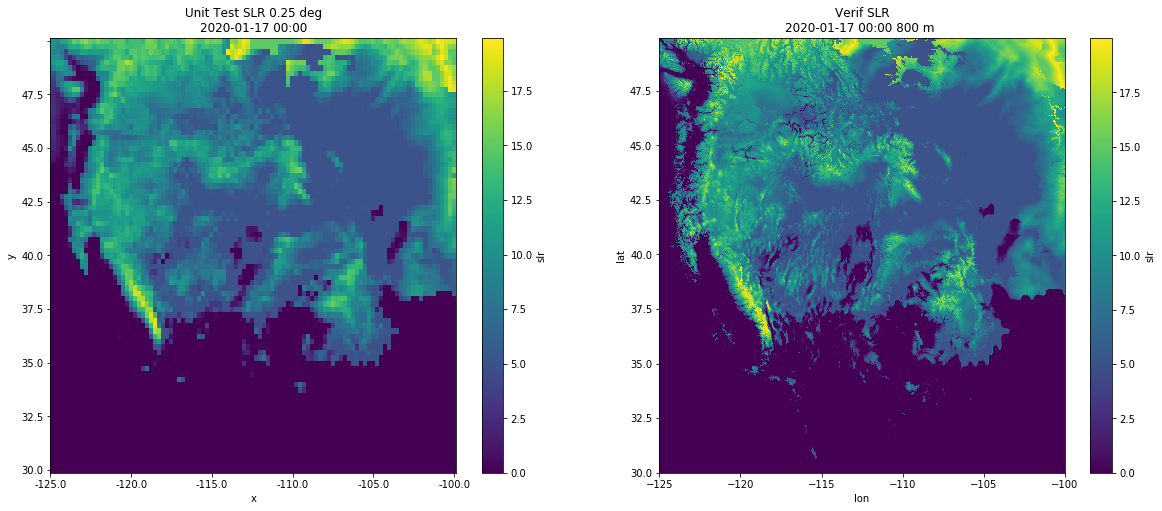

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')
idata['slr'].plot(ax=ax[0])
verif['slr'].plot(ax=ax[1])

ax[0].set_xlim(left=20)
ax[0].set_xticks(np.linspace(20, 120, 6))
ax[0].set_xticklabels(np.linspace(-125, -100, 6).astype(int))
ax[0].set_yticks(np.linspace(0, 80, 9))
ax[0].set_yticklabels(np.arange(30, 50, 2.5))

ax[0].set_title('Unit Test SLR 0.25 deg\n%s'%time)
ax[1].set_title('Verif SLR\n%s 800 m '%time)
plt.show()

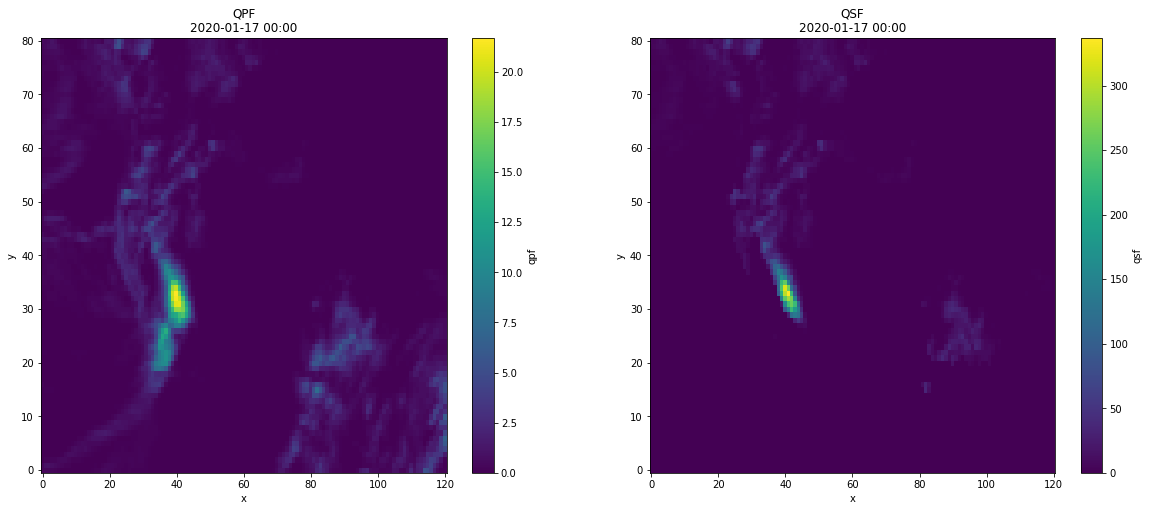

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')
idata['qpf'].plot(ax=ax[0])
idata['qsf'].plot(ax=ax[1])
ax[0].set_title('QPF\n%s'%time)
ax[1].set_title('QSF\n%s'%time)
plt.show()